Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that load_imgs write to a DataFrame rather than an array

In [1]:
import config
import helper_fxns as hf
import transforms as tr
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyelastix
import requests
import sys
import time
%matplotlib inline

In [23]:
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(config)

<module 'config' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\config.py'>

In [2]:
C = config.Config()

In [3]:
def add_voi(voi_df, mrn, x, y, z, cls, flipz, return_id=False):
    """Append voi info to the dataframe voi_df."""
    
    #vois.append([str(mrn) + ".npy", x[0], x[1], y[0], y[1], z[0], z[1], cls])
    if len(voi_df) == 0:
        i = 0
    else:
        i = voi_df.index[-1]+1
        
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]
    
    if return_id:
        row_id = ''.join(map(str, [mrn, x[0], y[0], z[0]]))
        voi_df.loc[i] = [str(mrn) + ".npy", x[0], x[1], y[0], y[1], z[0], z[1], cls, flipz, dx, dy, dz, row_id]
        return voi_df, row_id
        
    else:
        row_id = mrn
        voi_df.loc[i] = [row_id, x[0], x[1], y[0], y[1], z[0], z[1], dx, dy, dz]
        return voi_df

In [4]:
def preprocess_df(df):
    """Select only rows for this run. Collect MRNs and voi coordinates."""
    
    df = df[(df['Run'] <= 2) & (df['Image type'].isin(['AP-T1', 'VP-T1']))].dropna(subset=["x1"])
    return df.drop(set(df.columns).difference(['Patient E Number', 
          'x1', 'x2', 'y1', 'y2', 'z1', 'z2', 'Image type', 'Flipped',
          'x3', 'x4', 'y3', 'y4', 'z3', 'z4', 'Image type2']), axis=1)

In [11]:
def load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs, verbose=False):
    """Load images stored in img_dir with class name cls and stored in excel spreadsheet xls_name with name sheetname.
    Saves images to save_dir and saves vois to the global vois variable.
    Scales images and VOIs so that each voxel is 1.5 x 1.5 x 4 cm
    """
    
    print("\nLoading DCMs for class", cls)
    
    voi_df_art, voi_df_ven = voi_dfs
    df = pd.read_excel(xls_name, sheetname=sheetname)
    df = preprocess_df(df)
    mrns = list(set(df['Patient E Number'].dropna().astype(str).tolist()))
    s = time.time()
    target_dims = [1.5, 1.5, 4]
    load_time = 0
    reg_time = 0

    for cnt, mrn in enumerate(mrns):
        if os.path.exists(save_dir + "\\" + mrn + ".npy"):
            continue
            
        df_subset = df.loc[df['Patient E Number'].astype(str) == mrn]
        
        subdir = img_dir+"\\"+mrn # img_dir+"\\"+cls +"\\"+mrn

        t_load = time.time()
        art[mrn], cur_dims = hf.dcm_load(subdir+r"\T1_AP")
        try:
            ven[mrn], _ = hf.dcm_load(subdir+r"\T1_VP")
        except:
            print("No venous phase for", mrn)
            continue

        #pre[mrn], _ = hf.dcm_load(subdir+r"\T1_BL")
        #equ[mrn] = hf.dcm_load(subdir+r"\T1_EQ")
        #t2[mrn], _ = hf.dcm_load(subdir+r"\T2")
        load_time += time.time() - t_load

        # assume that VP-T1 will have been specified completely for each MRN
        if "Image type2" not in df_subset.columns or df_subset.iloc[0]["Image type2"] != "VP-T1":
            ven[mrn], _ = hf.reg_imgs(moving=ven[mrn], fixed=art[mrn], params=params, rescale_only=False)
        #t2[mrn], reg_scale = reg_imgs(moving=t2[mrn], fixed=art[mrn], params=params, rescale_only=False)

        #img = np.expand_dims(art[mrn], axis=3)
        img = np.transpose(np.stack((art[mrn], ven[mrn])), (1,2,3,0))

        #mask_file = base_dir + "\\" + mrn + r'\00_segs\liver.ids'
        #img = apply_mask(img, mask_file)

        #nonzeros = np.nonzero(img)
        #minx, maxx = min(nonzeros[0]), max(nonzeros[0])
        #miny, maxy = min(nonzeros[1]), max(nonzeros[1])
        #minz, maxz = min(nonzeros[2]), max(nonzeros[2])
        #img = img[minx:maxx, miny:maxy, minz:maxz, :]

        img, vox_scale = hf.rescale(img, target_dims, cur_dims)

        np.save(save_dir + "\\" + mrn, img)

        for _, row in df_subset.iterrows():
                
            x = (int(row['x1']), int(row['x2']))
            y = (int(row['y1']), int(row['y2']))
            z = (int(row['z1']), int(row['z2']))

            y = (art[mrn].shape[1]-y[1], art[mrn].shape[1]-y[0]) # flip y
            if row['Flipped'] != "Yes":
                z = (art[mrn].shape[2]-z[1], art[mrn].shape[2]-z[0]) # flip z

            x,y,z = hf.scale_vois(x, y, z, vox_scale)

            #x = (x[0] - minx, x[1] - minx)
            #y = (y[0] - miny, y[1] - miny)
            #z = (z[0] - minz, z[1] - minz)

            #if row['Image type'] == 'VP-T1':
            #    voi_df_ven = add_voi(voi_df_ven, mrn, x,y,z, cls, row['Flipped'] == "Yes")
            #else:
            voi_df_art, art_id = add_voi(voi_df_art, mrn, x,y,z, cls, row['Flipped'] == "Yes", return_id = True)
                
            if row['Image type2'] == 'VP-T1':
                voi_df_ven = add_voi(voi_df_ven, art_id, x,y,z)

        if verbose:
            print(mrn, "%d out of %d MRNs loaded" % (cnt+1, len(mrns)))
        else:
            print(".", end="")
            
    print("Overall time: %s" % str(time.time() - s))
    #print("Time to load dcms: %s" % str(load_time))
    #print("Time registering: %s" % str(reg_time))
    return voi_df_art, voi_df_ven

In [12]:
ven = {}
art = {}

voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls", "flipz", "dx", "dy", "dz", "id"])

#voi_df_ven only contains entries where manually specified
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2", "dx", "dy", "dz"])

params = pyelastix.get_default_params(type="AFFINE")

In [13]:
save_dir = C.full_img_dir
voi_dfs = [voi_df_art, voi_df_ven]
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
xls_name = 'Z:\\Prototype1c.xlsx'
base_dir = "Z:"

### Run 1

In [14]:
img_dir = base_dir+'\\simple_cysts'
cls = 'cyst'
sheetname="Hepatic Cyst"
voi_dfs = load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs)

img_dir = base_dir+'\\OPTN5A'
cls = 'hcc'
sheetname="OPTN 5A"
voi_dfs = load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs)

img_dir = base_dir+'\\optn5b'
cls = 'hcc'
sheetname="OPTN 5B"
voi_dfs = load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs)

img_dir = base_dir+'\\hemangioma'
cls = 'hemangioma'
sheetname="Hemangioma"
voi_dfs = load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs)


Loading DCMs for class cyst


KeyError: 'Image type2'

Loading DCMs for class cyst
.........................................Overall time: 295.843642950058

Loading DCMs for class hcc
........Overall time: 57.52138328552246

Loading DCMs for class hcc
.................................Overall time: 223.19729280471802

### Run 2

In [13]:
img_dir = base_dir+'\\fnh'
cls = 'fnh'
sheetname="FNH"
voi_dfs = load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs)


Loading DCMs for class fnh
..........................Overall time: 1578.3234589099884


### Run 3

In [14]:
img_dir = base_dir+'\\adenoma'
cls = 'adenoma'
sheetname="Adenoma"
voi_dfs = load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs)

img_dir = base_dir+'\\colorectal'
cls = 'colorectal'
sheetname="Colorectal"
voi_dfs = load_imgs(img_dir, cls, xls_name, sheetname, save_dir, voi_dfs)


Loading DCMs for class adenoma
Z:\adenoma\12159074\T1_VP NO_DICOM_FILES_FOUND
No venous phase for 12159074
..........Z:\adenoma\E100459749\T1_VP [WinError 3] The system cannot find the path specified: 'Z:\\adenoma\\E100459749\\T1_VP'
No venous phase for E100459749
...Overall time: 799.2241818904877


for mrn in mrns:
    if not os.path.exists("raw_imgs\\fnh\\" + mrn + "\\T1_AP"):
        print("raw_imgs\\fnh\\" + mrn + "\\T1_AP")

In [ ]:
voi_df_art, voi_df_ven = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)

In [264]:
# vois = np.unique(vois, axis=0)
#with open('train_list.txt', 'w') as f:
#    for voi in vois:
#        f.write(",".join([str(x) for x in voi]) + "\n")

In [20]:
#voi_df = pd.DataFrame(vois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()

In [323]:
pd.value_counts(voi_df['cls'])

cyst          75
fnh           60
hemangioma    54
hcc           51
Name: cls, dtype: int64

In [62]:
voi_df = pd.read_csv('vois.csv')

In [57]:
img_fn = "12799025.npy"
voi_df[voi_df["Filename"] == img_fn]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,dx,dy,dz
113,12789019.npy,104,123,89,106,28,34,hcc,True,19,17,6
114,12789019.npy,54,77,88,111,42,50,hcc,True,23,23,8


In [66]:
voi_df = hf.flipz(img_fn, voi_df)

In [146]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

12229245.npy
12302576.npy
12426594.npy
12451831.npy
12712463.npy
12757450.npy
12970726.npy
13133279.npy
13203550.npy
13266654.npy
E100314676.npy
E101006207.npy
E101516755.npy
E101544573.npy
E101579471.npy
E101808884.npy
E102373071.npy


In [ ]:
12239513, 12970726, 13133279, E100587476

In [85]:
voi_df = pd.read_csv('vois.csv')

In [322]:
voi_df = voi_df[voi_df["cls"] != "adenoma"]

In [38]:
def plot_section(img, df, pad=30, flipz=False):
    if flipz=="both":
        plt.subplot(121)
        plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')
        
        plt.subplot(122)
        plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                    df['y2']+pad:df['y1']-pad:-1,
                                    img.shape[2]-(df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')

def plot_section_xyz(img, x,y,z, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[x[0]-pad:x[1]+pad, y[1]+pad:y[0]-pad:-1, (z[0]+z[1])//2,0], (1,0)), cmap='gray')
    

def plot_section_mrn(mrn,x,y,z, pad=30):
    plt.subplot(211)
    plt.imshow(np.transpose(art[mrn][x[0]-pad:x[1]+pad, y[1]+pad:y[0]-pad:-1, (z[0]+z[1])//2], (1,0)), cmap='gray')

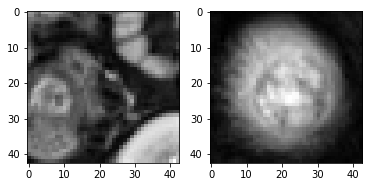

In [40]:
xls_name = 'Z:\\Prototype1b.xlsx'
base_dir = "Z:"#'raw_imgs'
img_dir = base_dir+'\\hemangioma'
cls = 'hemangioma'
sheetname="Hemangioma"

need_dcm = False
mrns = ["12789019"]#list(set(df['Patient E Number'].dropna().astype(str).tolist()))
target_dims = [1.5, 1.5, 4]

if need_dcm:
    voi_df = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls", "flipz"])
    df = pd.read_excel(xls_name, sheetname)
    df = preprocess_df(df)
    for cnt, mrn in enumerate(mrns):
        df_subset = df.loc[df['Patient E Number'].astype(str) == mrn]
        subdir = img_dir+"\\"+mrn
        art[mrn], cur_dims = hf.dcm_load(subdir+r"\T1_AP")
        img = np.expand_dims(art[mrn], axis=3)
        #img, vox_scale = hf.rescale(img, target_dims, cur_dims)

        np.save(save_dir + "\\" + mrn, img)

        for _, row in df_subset.iterrows():
            x = (int(row['x1']), int(row['x2']))
            y = (int(row['y1']), int(row['y2']))
            z = (int(row['z1']), int(row['z2']))

            y = (art[mrn].shape[1]-y[1], art[mrn].shape[1]-y[0]) # flip y
            if row['Flipped'] != "Yes":
                z = (art[mrn].shape[2]-z[1], art[mrn].shape[2]-z[0]) # flip z

            #x,y,z = scale_vois(x, y, z, vox_scale)

            add_voi(mrn, x,y,z, cls, row['Flipped'] != "Yes")
        
mrn = mrns[0]
img_fn = mrn + ".npy"
img = np.load("full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], flipz="both", pad=10)

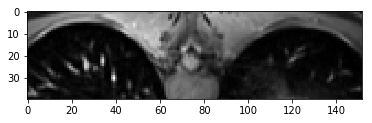

In [145]:
plt.imshow(np.transpose(img[img.shape[0]*1//5:img.shape[0]*4//5,
                            img.shape[1]*1//5:img.shape[1]*2//5,
                            img.shape[2]*5//6, 0], (1,0)), cmap='gray')

In [ ]:
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[1], pad=10)

In [110]:
dims

array([ 1.5625,  1.5625,  3.5   ], dtype=float32)

In [108]:
img = np.transpose(np.stack((img, img)), (1,2,3,0))

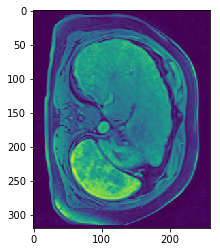

In [50]:
plt.imshow(img[:,:,60,0])

In [11]:
img, vox_scale = hf.rescale(img, target_dims, cur_dims)

AttributeError: module 'helper_fxns' has no attribute 'rescale'

In [69]:
x = (74, 91)
y = (128, 145)
z = (43, 50)
y = (img.shape[1]-y[1], img.shape[1]-y[0]) # flip y
z = (img.shape[2]-z[1], img.shape[2]-z[0]) # flip z

In [75]:
x = (round(x[0]*vox_scale[0]), round(x[1]*vox_scale[0]))
y = (round(y[0]*vox_scale[1]), round(y[1]*vox_scale[1]))
z = (round(z[0]*vox_scale[2]), round(z[1]*vox_scale[2]))

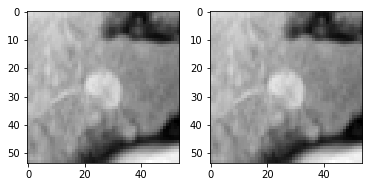

In [78]:
plot_section_xyz(img, x, y, z, pad=20)